In [120]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb


import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings('ignore')

In [121]:
df = pd.read_csv("data/daily_merged_hydro_climate.csv")
df.head()

,date,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C)_mean,Temperature (°C)_min,Temperature (°C)_max,...,V Wind Component (m/s)_mean,Total Precipitation (mm)_sum,Snowfall (mm)_sum,Snow Cover (%)_mean,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
0,2023-06-03,consumer_device_3_data_user_9,0.000576,0.08,0.006786,0.005324,0.000922,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,9,1.344820,0,0,1
1,2023-06-03,consumer_device_3_data_user_4,0.000647,0.09,0.007634,0.005468,0.001066,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,4,1.344820,0,1,0
2,2023-06-03,consumer_device_3_data_user_3,0.000719,0.10,0.008482,0.005468,0.001183,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,3,1.343381,1,0,0
3,2023-06-03,consumer_device_3_data_user_11,0.000647,0.09,0.007634,0.005180,0.001009,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,11,1.344820,0,0,1
4,2023-06-03,consumer_device_3_data_user_5,0.000647,0.09,0.007634,0.005612,0.001094,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,5,1.344820,0,0,1


In [122]:
df = df.drop('data_user', axis=1)

In [123]:
df.columns

Index(['date', 'Source', 'current_mean', 'current_max', 'current_std',
       'power_factor_mean', 'kwh_sum', 'Temperature (°C)_mean',
       'Temperature (°C)_min', 'Temperature (°C)_max',
       'Dewpoint Temperature (°C)_mean', 'Dewpoint Temperature (°C)_min',
       'Dewpoint Temperature (°C)_max', 'U Wind Component (m/s)_mean',
       'V Wind Component (m/s)_mean', 'Total Precipitation (mm)_sum',
       'Snowfall (mm)_sum', 'Snow Cover (%)_mean', 'consumer_device',
       'voltage_value', 'is_red', 'is_blue', 'is_yellow'],
      dtype='object')

In [124]:
# Dictionary mapping old names to new names
new_names = {
    'date': 'Date',
    'Source': 'Source',
    'current_mean': 'Current_Mean',
    'current_max': 'Current_Max',
    'current_std': 'Current_Std',
    'power_factor_mean': 'PowerFactor_Mean',
    'kwh_sum': 'KWh_Sum',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean',
    'consumer_device': 'Device',
    'voltage_value': 'Voltage',
    'is_red': 'Red_Flag',
    'is_blue': 'Blue_Flag',
    'is_yellow': 'Yellow_Flag'
}


In [125]:
df.rename(columns=new_names, inplace=True)


In [126]:
df.head()

,Date,Source,Current_Mean,Current_Max,Current_Std,PowerFactor_Mean,KWh_Sum,Temp_Mean,Temp_Min,Temp_Max,...,U_Wind_Mean,V_Wind_Mean,Precipitation_Sum,Snowfall_Sum,SnowCover_Mean,Device,Voltage,Red_Flag,Blue_Flag,Yellow_Flag
0,2023-06-03,consumer_device_3_data_user_9,0.000576,0.08,0.006786,0.005324,0.000922,1.86028,-1.513861,7.199731,...,0.025054,-0.657726,0.004557,0.0,99.972656,consumer_device_3,1.344820,0,0,1
1,2023-06-03,consumer_device_3_data_user_4,0.000647,0.09,0.007634,0.005468,0.001066,1.86028,-1.513861,7.199731,...,0.025054,-0.657726,0.004557,0.0,99.972656,consumer_device_3,1.344820,0,1,0
2,2023-06-03,consumer_device_3_data_user_3,0.000719,0.10,0.008482,0.005468,0.001183,1.86028,-1.513861,7.199731,...,0.025054,-0.657726,0.004557,0.0,99.972656,consumer_device_3,1.343381,1,0,0
3,2023-06-03,consumer_device_3_data_user_11,0.000647,0.09,0.007634,0.005180,0.001009,1.86028,-1.513861,7.199731,...,0.025054,-0.657726,0.004557,0.0,99.972656,consumer_device_3,1.344820,0,0,1
4,2023-06-03,consumer_device_3_data_user_5,0.000647,0.09,0.007634,0.005612,0.001094,1.86028,-1.513861,7.199731,...,0.025054,-0.657726,0.004557,0.0,99.972656,consumer_device_3,1.344820,0,0,1


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136409 entries, 0 to 136408
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               136409 non-null  object 
 1   Source             136409 non-null  object 
 2   Current_Mean       136409 non-null  float64
 3   Current_Max        136409 non-null  float64
 4   Current_Std        136409 non-null  float64
 5   PowerFactor_Mean   136409 non-null  float64
 6   KWh_Sum            136409 non-null  float64
 7   Temp_Mean          136409 non-null  float64
 8   Temp_Min           136409 non-null  float64
 9   Temp_Max           136409 non-null  float64
 10  Dewpoint_Mean      136409 non-null  float64
 11  Dewpoint_Min       136409 non-null  float64
 12  Dewpoint_Max       136409 non-null  float64
 13  U_Wind_Mean        136409 non-null  float64
 14  V_Wind_Mean        136409 non-null  float64
 15  Precipitation_Sum  136409 non-null  float64
 16  Sn

In [128]:
df.columns

Index(['Date', 'Source', 'Current_Mean', 'Current_Max', 'Current_Std',
       'PowerFactor_Mean', 'KWh_Sum', 'Temp_Mean', 'Temp_Min', 'Temp_Max',
       'Dewpoint_Mean', 'Dewpoint_Min', 'Dewpoint_Max', 'U_Wind_Mean',
       'V_Wind_Mean', 'Precipitation_Sum', 'Snowfall_Sum', 'SnowCover_Mean',
       'Device', 'Voltage', 'Red_Flag', 'Blue_Flag', 'Yellow_Flag'],
      dtype='object')

In [129]:
df.isnull().sum()

Date                 0
Source               0
Current_Mean         0
Current_Max          0
Current_Std          0
PowerFactor_Mean     0
KWh_Sum              0
Temp_Mean            0
Temp_Min             0
Temp_Max             0
Dewpoint_Mean        0
Dewpoint_Min         0
Dewpoint_Max         0
U_Wind_Mean          0
V_Wind_Mean          0
Precipitation_Sum    0
Snowfall_Sum         0
SnowCover_Mean       0
Device               0
Voltage              0
Red_Flag             0
Blue_Flag            0
Yellow_Flag          0
dtype: int64

In [130]:
print(f"Number of unique sources: {len(df['Source'].unique())}")
print(f"Number of days: {len(df['Date'].unique())}")

Number of unique sources: 585
Number of days: 479


In [131]:
df_total = df[["Date", "KWh_Sum"]].groupby("Date", as_index=False).sum()

<Axes: title={'center': 'Total Daily Power Consumption'}, xlabel='Date'>

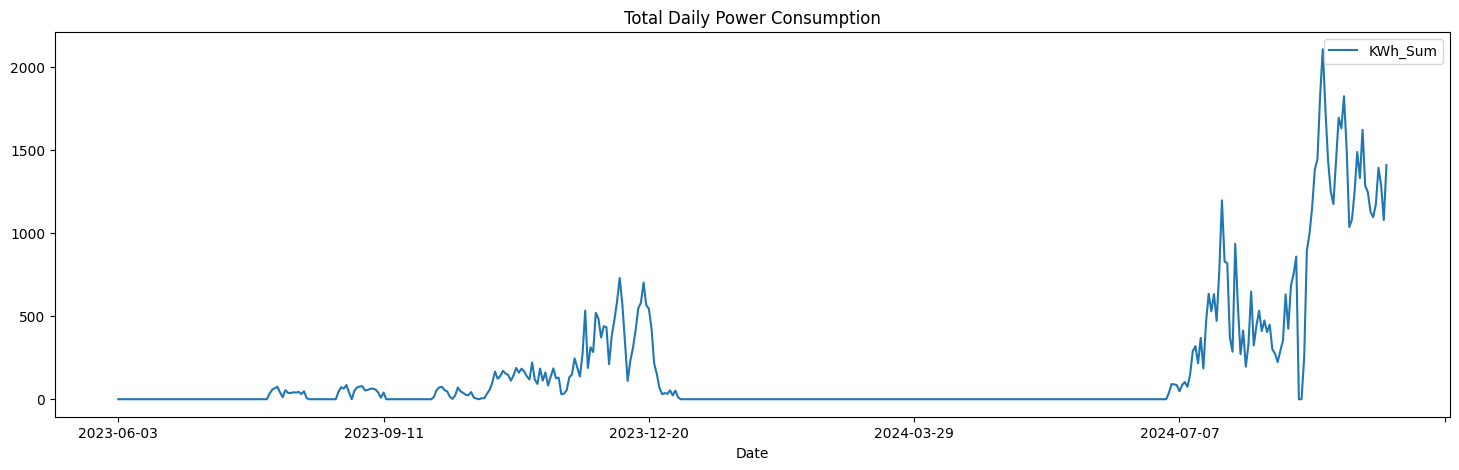

In [132]:
df_total.plot(x="Date", y="KWh_Sum", figsize=(18, 5), title="Total Daily Power Consumption")

In [133]:
# These are devices with weak signals which we can exclude from the analysis - these were mentioned in the samplesubmission notebook
weak_to_drop = ["consumer_device_3", "consumer_device_5", "consumer_device_11", "consumer_device_14", "consumer_device_15", "consumer_device_17", "consumer_device_24", "consumer_device_25", "consumer_device_27", "consumer_device_33", "consumer_device_4", "consumer_device_9"]

In [134]:
df = df[~(df["Device"].isin(weak_to_drop))]

In [135]:
#-----------------------------------------------------------------------------------------------
print(f"Number of unique sources after dropping weak devices: {len(df['Source'].unique())}")
#-----------------------------------------------------------------------------------------------

Number of unique sources after dropping weak devices: 421


Now we need to make sure that all the Sources signals have the same lenght over time. We will fill with ceros when there is no data entries for certain days. 

What this does:

- Every (Date, Source) exists.

- KWh_Sum is 0 where that pair was missing (inactive day).

- Climate columns are true daily values (not zeroed).

- Electricals (Current_*, PowerFactor_Mean) remain NaN on inserted rows (no fake values).

- Static flags (Red/Blue/Yellow, Device, Voltage) are filled from the per-Source setting.

In [136]:
# Ensure proper dtypes & sorting
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Source", "Date"])


climate_cols = [
    "Temp_Mean","Temp_Min","Temp_Max",
    "Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean",
    "Precipitation_Sum","Snowfall_Sum","SnowCover_Mean"
]

static_cols = ["Device", "Voltage", "Red_Flag", "Blue_Flag", "Yellow_Flag"]

# Climate by day 
# We assume climate is identical across Sources for the same Date.
weather_by_day = (
    df.groupby("Date", as_index=False)[climate_cols]
      .mean()   # mean/first are equivalent if identical across sources
)

# Build full Date × Source grid over the observed date span
all_dates   = pd.date_range(df["Date"].min(), df["Date"].max(), freq="D")
all_sources = df["Source"].unique()
grid = (pd.MultiIndex.from_product([all_dates, all_sources], names=["Date","Source"])
        .to_frame(index=False))

# Merge climate onto the grid (fills climate for every Source, every day)
df_full = grid.merge(weather_by_day, on="Date", how="left")

# Bring in observed per-(Date, Source) values from original df
# Only the columns that vary by (Date, Source). We’ll add KWh plus electricals if you want them.
per_obs_cols = ["Date","Source","KWh_Sum",
                "Current_Mean","Current_Max","Current_Std","PowerFactor_Mean"]
per_obs_cols = [c for c in per_obs_cols if c in df.columns]  # keep only existing

df_full = df_full.merge(df[per_obs_cols], on=["Date","Source"], how="left")

# Fill ONLY the target with zeros when missing; keep others as NaN
df_full["KWh_Sum"] = df_full["KWh_Sum"].fillna(0)

# Static/source-level info: fill from per-source values (mode/last known)
# Build a per-source table of static attributes
def per_source_static(g):
    out = {}
    for col in static_cols:
        if col not in g.columns:
            continue
        s = g[col].dropna()
        if s.empty:
            out[col] = np.nan
        else:
            # choose the most frequent value; if tie, take the last observed
            mode_vals = s.mode()
            out[col] = mode_vals.iloc[0] if not mode_vals.empty else s.iloc[-1]
    return pd.Series(out)

static_map = (df.sort_values("Date")
                .groupby("Source")
                .apply(per_source_static)
                .reset_index())

# Merge static values and fill where missing
df_full = df_full.merge(static_map, on="Source", how="left", suffixes=("", "_static"))
for col in static_cols:
    if col in df_full.columns and f"{col}_static" in df_full.columns:
        df_full[col] = df_full[col].fillna(df_full[f"{col}_static"])
        df_full.drop(columns=[f"{col}_static"], inplace=True)

# Final tidy-up
df_full = df_full.sort_values(["Source","Date"]).reset_index(drop=True)



In [137]:
df_full.tail(10)

,Date,Source,Temp_Mean,Temp_Min,Temp_Max,Dewpoint_Mean,Dewpoint_Min,Dewpoint_Max,U_Wind_Mean,V_Wind_Mean,...,KWh_Sum,Current_Mean,Current_Max,Current_Std,PowerFactor_Mean,Device,Voltage,Red_Flag,Blue_Flag,Yellow_Flag
192808,2024-09-14,consumer_device_8_data_user_9,7.519299,3.609872,11.542627,5.544675,3.037103,9.039194,-0.116898,0.231795,...,0.277851,0.087639,0.10,0.014141,0.731806,consumer_device_8,0.0,0,0,1
192809,2024-09-15,consumer_device_8_data_user_9,7.491526,3.019357,12.038309,4.165635,1.784113,7.362848,-0.028957,0.029309,...,0.269867,0.084618,0.10,0.019196,0.714583,consumer_device_8,0.0,0,0,1
192810,2024-09-16,consumer_device_8_data_user_9,7.619009,1.611978,13.058771,2.634636,0.808084,5.488199,0.013803,-0.156189,...,0.272034,0.085382,0.10,0.020966,0.707812,consumer_device_8,0.0,0,0,1
192811,2024-09-17,consumer_device_8_data_user_9,6.844599,-0.173071,11.830164,3.147345,-0.640860,7.134012,-0.047540,-0.164794,...,0.268797,0.086840,0.11,0.018500,0.718229,consumer_device_8,0.0,0,0,1
192812,2024-09-18,consumer_device_8_data_user_9,8.097630,-1.204611,14.658624,1.675447,-1.940741,3.374109,-0.059041,-0.344863,...,0.270210,0.084201,0.11,0.017690,0.719653,consumer_device_8,0.0,0,0,1
192813,2024-09-19,consumer_device_8_data_user_9,10.415409,3.567911,15.753839,1.626889,0.011087,3.489511,-0.011655,-0.156432,...,0.275204,0.084931,0.11,0.014338,0.729792,consumer_device_8,0.0,0,0,1
192814,2024-09-20,consumer_device_8_data_user_9,12.154204,4.974176,18.019144,1.086294,-0.760352,4.018442,-0.133177,-0.239482,...,0.260286,0.082083,0.10,0.018568,0.716354,consumer_device_8,0.0,0,0,1
192815,2024-09-21,consumer_device_8_data_user_9,13.219773,6.373270,19.153406,1.432244,-0.518103,5.083414,-0.098764,-0.306270,...,0.255620,0.080937,0.10,0.021466,0.702812,consumer_device_8,0.0,0,0,1
192816,2024-09-22,consumer_device_8_data_user_9,14.080013,6.942697,20.946268,1.195233,-2.151160,4.965402,-0.069137,-0.309662,...,0.236559,0.072813,0.09,0.031303,0.631840,consumer_device_8,0.0,0,0,1
192817,2024-09-23,consumer_device_8_data_user_9,13.384137,4.670419,21.034174,3.404842,-2.298209,9.051385,0.050238,-0.223926,...,0.295538,0.088646,0.10,0.009402,0.743229,consumer_device_8,0.0,0,0,1


In [138]:
df_full.isnull().sum()

Date                      0
Source                    0
Temp_Mean                 0
Temp_Min                  0
Temp_Max                  0
Dewpoint_Mean             0
Dewpoint_Min              0
Dewpoint_Max              0
U_Wind_Mean               0
V_Wind_Mean               0
Precipitation_Sum         0
Snowfall_Sum              0
SnowCover_Mean            0
KWh_Sum                   0
Current_Mean         109326
Current_Max          109326
Current_Std          109326
PowerFactor_Mean     109326
Device                    0
Voltage                   0
Red_Flag                  0
Blue_Flag                 0
Yellow_Flag               0
dtype: int64

Add Calendar Features:

In [139]:
df_full["DayOfWeek"] = df_full["Date"].dt.dayofweek
df_full["Month"] = df_full["Date"].dt.month
df_full["IsWeekend"] = (df_full["DayOfWeek"] >= 5).astype(int)


Step 5: Add Lag & Rolling Features

In [140]:
def add_lag_features(df, lags=[1, 7], rolling=[7, 30]):
    df = df.copy()
    for lag in lags:
        df[f'KWh_Lag{lag}'] = df.groupby("Source")["KWh_Sum"].shift(lag)
    for window in rolling:
        df[f'KWh_Roll{window}_Mean'] = (
            df.groupby("Source")["KWh_Sum"]
              .shift(1).rolling(window).mean()
        )
        df[f'KWh_Roll{window}_Std'] = (
            df.groupby("Source")["KWh_Sum"]
              .shift(1).rolling(window).std()
        )
    return df

df_full = add_lag_features(df_full)


Train/Test Split (Time-based):

In [141]:
# Pick a cutoff date (e.g. last 30 days as validation)
cutoff_date = df_full["Date"].max() - pd.Timedelta(days=30)

train = df_full[df_full["Date"] <= cutoff_date]
test  = df_full[df_full["Date"] > cutoff_date]

print(train.shape, test.shape)


(180188, 32) (12630, 32)


Feature/Target Definition: 

Training with all features available.

But remember: for later, we will have only climate + calendar + lag/rolling (not current/voltage).

So we’ll keep two versions:

- Experimental (use all features).

- Final model (climate + calendar + lag/rolling only).


In [142]:
target = "KWh_Sum"

# Option A (all features)
features_all = [col for col in df_full.columns if col not in ["Date", "KWh_Sum", "Source"]]

# Option B (safe features for future prediction)
climate_features = ['Temp_Mean','Temp_Min','Temp_Max',
                    'Dewpoint_Mean','Dewpoint_Min','Dewpoint_Max',
                    'U_Wind_Mean','V_Wind_Mean',
                    'Precipitation_Sum','Snowfall_Sum','SnowCover_Mean']
engineered_features = [c for c in df_full.columns if "Lag" in c or "Roll" in c]
calendar_features = ["DayOfWeek","Month","IsWeekend"]

features_safe = climate_features + engineered_features + calendar_features

X_train = train[features_safe]
y_train = train[target]
X_test  = test[features_safe]
y_test  = test[target]

Train a Baseline Model:

We’ll start with a Gradient Boosted Trees 

In [143]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")


Validation MAE: 1.60
Validation RMSE: 5.27


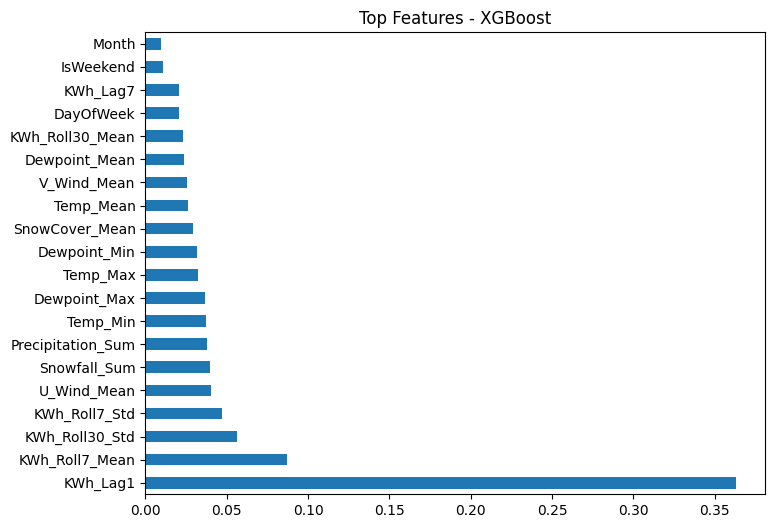

In [144]:
xgb_importance = pd.Series(model.feature_importances_, index=features_safe)
xgb_importance.sort_values(ascending=False).head(20).plot(kind="barh", figsize=(8,6))
plt.title("Top Features - XGBoost")
plt.show()


In [145]:
import matplotlib.pyplot as plt

def plot_source_predictions_full(df, y_true, y_pred, source_id):
    """
    Plot actual vs predicted kWh for a given Source over the full time range.
    
    df: dataframe with Date and Source columns (aligned with test set indices)
    y_true: array-like of true values
    y_pred: array-like of predictions
    source_id: the Source you want to plot
    """
    # Combine results
    results = df.copy()
    results["y_true"] = y_true
    results["y_pred"] = y_pred

    # Filter for one Source
    src_data = results[results["Source"] == source_id].sort_values("Date")

    # Plot full time range
    plt.figure(figsize=(14,6))
    plt.plot(src_data["Date"], src_data["y_true"], label="Actual", linewidth=2)
    plt.plot(src_data["Date"], src_data["y_pred"], label="Predicted", linestyle="--")
    plt.title(f"Source {source_id} - Actual vs Predicted kWh (Full Time Range)")
    plt.xlabel("Date")
    plt.ylabel("KWh_Sum")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


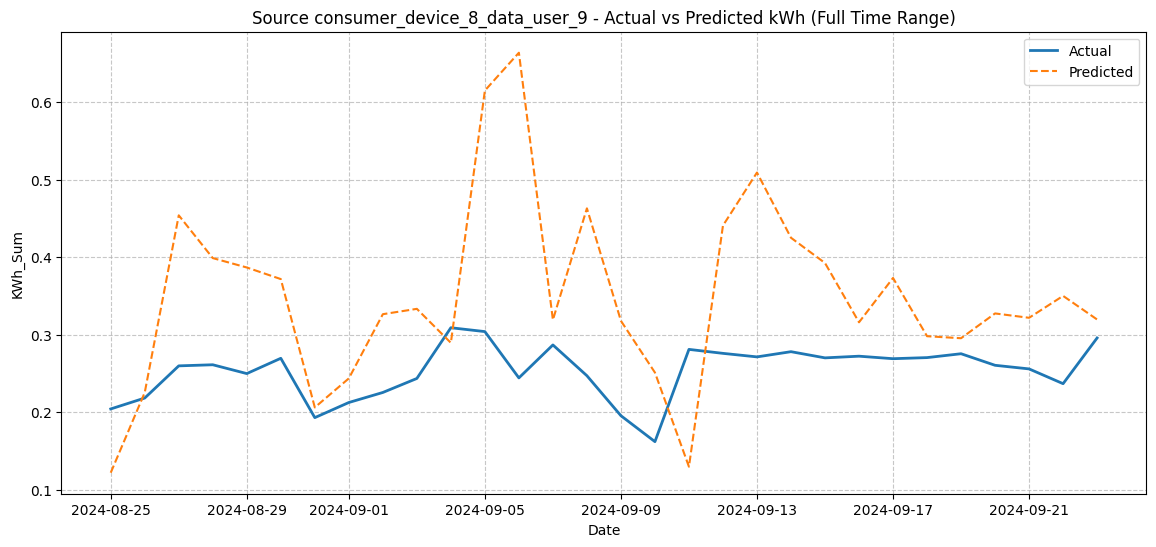

In [146]:
# y_pred = model.predict(X_test)
plot_source_predictions_full(test, y_test, y_pred, source_id="consumer_device_8_data_user_9")


To see total consumption:

In [147]:
def plot_total_consumption(test_df, y_true, y_pred):
    """
    Compare actual vs predicted total daily consumption (sum over Sources).
    
    test_df: dataframe with Date column (test set rows)
    y_true: array-like of true values
    y_pred: array-like of predictions
    """
    # Build results dataframe
    results = test_df.copy()
    results["y_true"] = y_true
    results["y_pred"] = y_pred

    # Aggregate by date
    agg = (
        results.groupby("Date")[["y_true", "y_pred"]]
        .sum()
        .reset_index()
        .sort_values("Date")
    )

    # Plot
    plt.figure(figsize=(14,6))
    plt.plot(agg["Date"], agg["y_true"], label="Actual Total", linewidth=2)
    plt.plot(agg["Date"], agg["y_pred"], label="Predicted Total", linestyle="--")
    plt.title("Total Daily Consumption (Actual vs Predicted)")
    plt.xlabel("Date")
    plt.ylabel("Total KWh")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    return agg  # optional: return aggregated dataframe


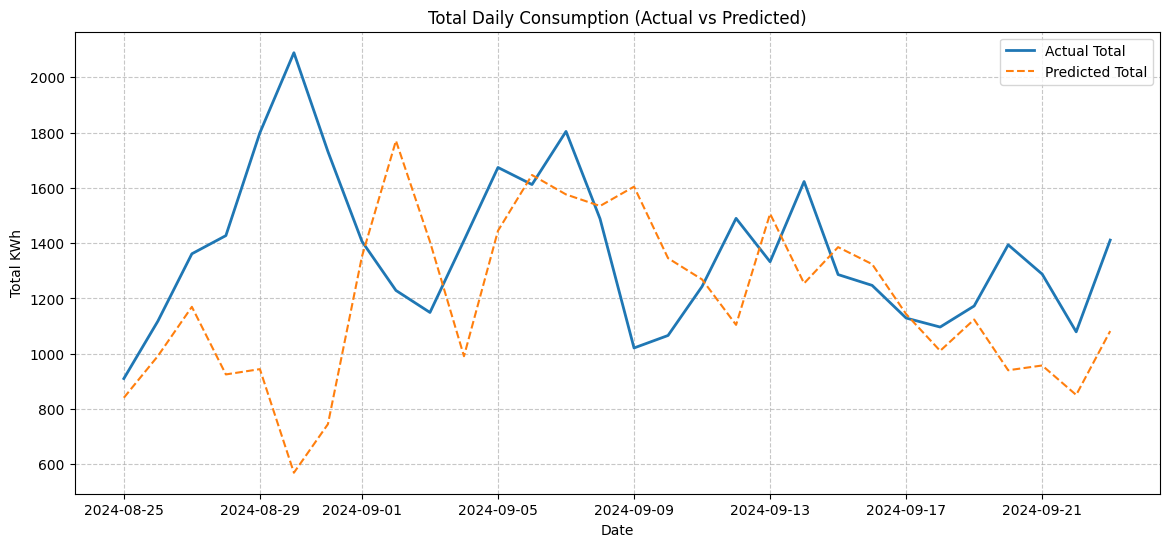

In [148]:
agg_results = plot_total_consumption(test, y_test, y_pred)


In [149]:
def plot_source_predictions_full_series(df, test_df, y_true, y_pred, source_id):
    """
    Plots actual vs predicted consumption for a given source over the entire time range.
    """
    # Restrict test_df and y_pred/y_true to this source
    mask = test_df["Source"] == source_id
    test_src = test_df[mask].copy()
    
    # Align predictions and true values to that subset
    test_src["y_true"] = y_true[mask].values
    test_src["y_pred"] = y_pred[mask].values

    # Plot
    plt.figure(figsize=(14,6))
    plt.plot(df[df["Source"] == source_id]["Date"], df[df["Source"] == source_id]["KWh_Sum"], 
             label="Actual (train+test full)", color="blue", alpha=0.5)
    plt.plot(test_src["Date"], test_src["y_true"], 
             label="Actual (test only)", color="green", linewidth=2)
    plt.plot(test_src["Date"], test_src["y_pred"], 
             label="Predicted (test)", color="red", linewidth=2, linestyle="--")
    
    plt.title(f"Power Consumption Prediction for {source_id}")
    plt.xlabel("Date")
    plt.ylabel("Daily kWh")
    plt.legend()
    plt.show()



In [150]:
def plot_total_consumption_full_series(df, test_df, y_true, y_pred):
    """
    Plot total consumption across all Sources, with full real series and predictions in test.
    """
    # Real full time series
    full_totals = df.groupby("Date")["KWh_Sum"].sum().reset_index()

    # Test with predictions
    test_res = test_df.copy()
    test_res["y_true"] = y_true
    test_res["y_pred"] = y_pred
    test_totals = test_res.groupby("Date")[["y_true", "y_pred"]].sum().reset_index()

    # Plot
    plt.figure(figsize=(14,6))
    plt.plot(full_totals["Date"], full_totals["KWh_Sum"], label="Actual (full)", linewidth=2)
    plt.plot(test_totals["Date"], test_totals["y_pred"], label="Predicted (test only)", linestyle="--", color="orange")
    plt.title("Total Consumption - Full Series with Predictions")
    plt.xlabel("Date")
    plt.ylabel("Total KWh")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


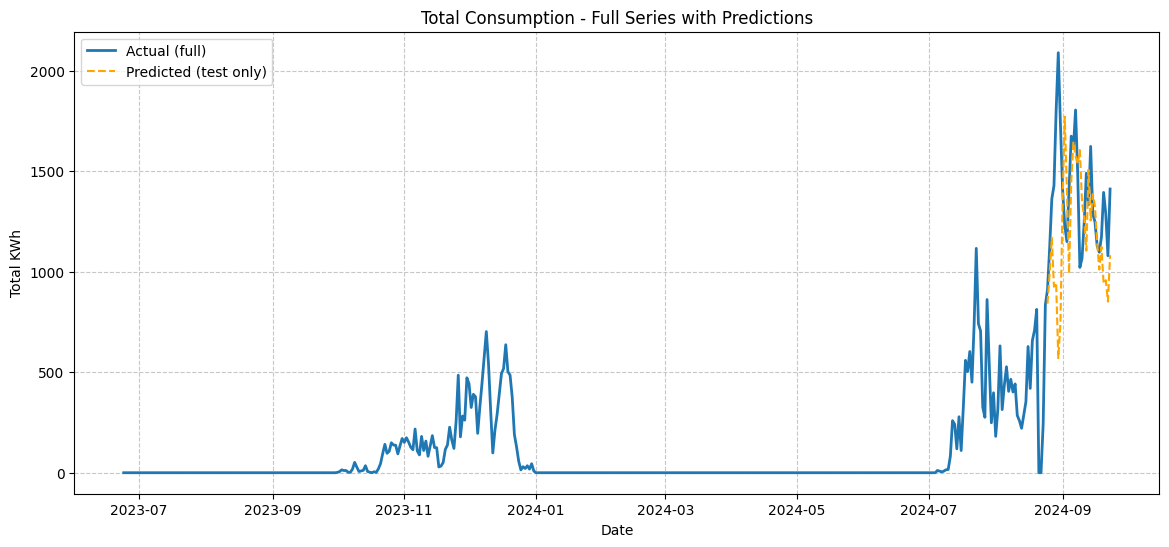

In [151]:


# Total
plot_total_consumption_full_series(df, test, y_test, y_pred)


In [152]:
df_full.columns


Index(['Date', 'Source', 'Temp_Mean', 'Temp_Min', 'Temp_Max', 'Dewpoint_Mean',
       'Dewpoint_Min', 'Dewpoint_Max', 'U_Wind_Mean', 'V_Wind_Mean',
       'Precipitation_Sum', 'Snowfall_Sum', 'SnowCover_Mean', 'KWh_Sum',
       'Current_Mean', 'Current_Max', 'Current_Std', 'PowerFactor_Mean',
       'Device', 'Voltage', 'Red_Flag', 'Blue_Flag', 'Yellow_Flag',
       'DayOfWeek', 'Month', 'IsWeekend', 'KWh_Lag1', 'KWh_Lag7',
       'KWh_Roll7_Mean', 'KWh_Roll7_Std', 'KWh_Roll30_Mean', 'KWh_Roll30_Std'],
      dtype='object')